# Лабораторная работа №4

## Сети с радиальными базисными элементами

## Вариант 23
Целью работы является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend

Сгенерирую псевдослучайные данные для обучения и тестирования.

In [2]:
def gen_random_ellipse_data(a, b, alpha, x_0, y_0, n):
    rand_nums = 2*np.pi*np.random.rand(n)
    x = x_0 + a * np.cos(rand_nums)
    y = y_0 + b * np.sin(rand_nums)
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return np.array([xr, yr])

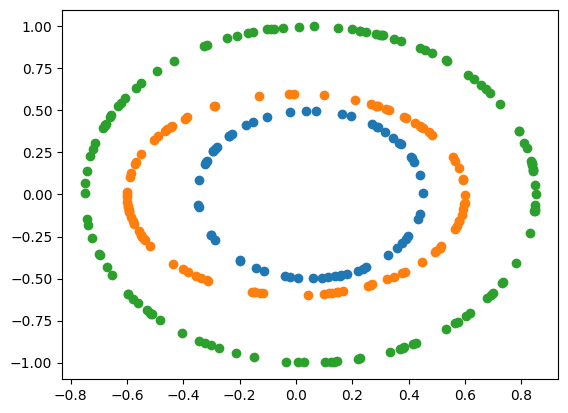

In [3]:
fig, ax = plt.subplots(1, 1)
data1_size = 60
data2_size = 100
data3_size = 120
data1 = gen_random_ellipse_data(0.4, 0.5, 0, 0.05, 0, data1_size)
data2 = gen_random_ellipse_data(0.6, 0.6, 0, 0.00, 0, data2_size)
data3 = gen_random_ellipse_data(0.8, 1, 0, 0.05, 0, data3_size)
ax.scatter(data1[0], data1[1])
ax.scatter(data2[0], data2[1])
ax.scatter(data3[0], data3[1])

plt.show()

Перегруппирую и разобью данные на тестовую и обучающую выборку.

In [4]:
data = np.concatenate([data1, data2, data3], axis=1)
data = data.transpose()
labels1 = np.array([[1, 0, 0] for i in range(data1_size)])
labels2 = np.array([[0, 1, 0] for i in range(data2_size)])
labels3 = np.array([[0, 0, 1] for i in range(data3_size)])
labels = np.concatenate([labels1, labels2, labels3], axis=0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=322)

Реализую радиально базисный слой, для построения нейросетевой модели.

In [5]:
class RBFLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBFLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # print(input_shape)
        self.mu = self.add_weight(name='mu', 
                                  shape=(input_shape[1], self.output_dim), 
                                  initializer='uniform', 
                                  trainable=True)
        self.sigma = self.add_weight(name='sigma', 
                                     shape=(self.output_dim, ), 
                                     initializer='uniform', 
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)
        
    def call(self, inputs):
        diff = backend.expand_dims(inputs) - self.mu
        return backend.exp(backend.sum(diff ** 2, axis=1) * self.sigma)

Построю и скомпилирую и обучу модель.

In [6]:
model = keras.models.Sequential()
model.add(RBFLayer(10, input_dim = 2))
model.add(keras.layers.Dense(3, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [7]:
epochs = 200
hist = model.fit(X_train, y_train, batch_size=5, epochs=epochs)

Epoch 1/200
40/40 [==============================] - 15s 23ms/step - loss: 0.2712 - mae: 0.4751
Epoch 2/200
40/40 [==============================] - 1s 14ms/step - loss: 0.2445 - mae: 0.4630
Epoch 3/200
40/40 [==============================] - 1s 12ms/step - loss: 0.2263 - mae: 0.4509
Epoch 4/200
40/40 [==============================] - 1s 19ms/step - loss: 0.2155 - mae: 0.4407
Epoch 5/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2105 - mae: 0.4331
Epoch 6/200
40/40 [==============================] - 1s 12ms/step - loss: 0.2070 - mae: 0.4283
Epoch 7/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2045 - mae: 0.4250
Epoch 8/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2020 - mae: 0.4206
Epoch 9/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2001 - mae: 0.4166
Epoch 10/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1979 - mae: 0.4137
Epoch 11/200
40/40 [============================

Нарисую результаты.

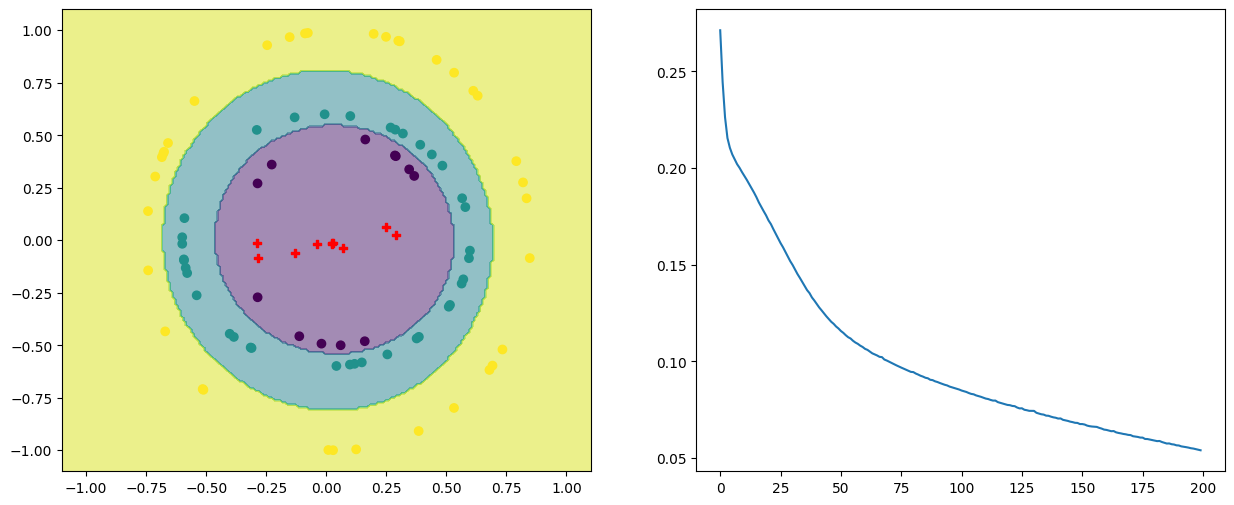

In [8]:
steps = 200
x_span = np.linspace(-1.1, 1.1, steps)
y_span = np.linspace(-1.1, 1.1, steps)
xx, yy = np.meshgrid(x_span, y_span)
grid_points = np.array([xx.ravel(), yy.ravel()])
grid_points = grid_points.transpose()

grid_predictions = model(grid_points)
grid_labels = np.argmax(grid_predictions, axis=1)

predictions = model(X_test)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

grid_labels = grid_labels.reshape(xx.shape)
ax[0].contourf(xx, yy, grid_labels, alpha=0.5)
ax[0].scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1))

mu_x = model.layers[0].get_weights()[0][0, :]
mu_y = model.layers[0].get_weights()[0][1, :]
ax[0].scatter(mu_x, mu_y, marker='P', color='red')

ax[1].plot(hist.history['loss'])

plt.show()

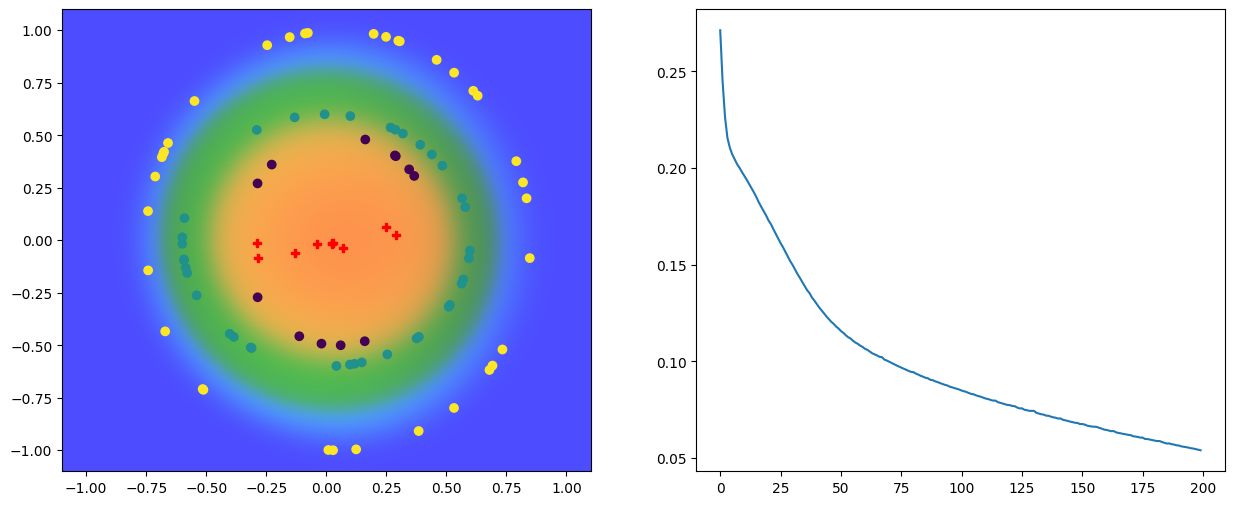

In [9]:
grid_predictions = model(grid_points).numpy().reshape(steps, steps, 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].imshow(grid_predictions, extent=(-1.1, 1.1, -1.1, 1.1), alpha=0.7, origin='lower', aspect='auto', interpolation='bilinear')
ax[0].scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1))

mu_x = model.layers[0].get_weights()[0][0, :]
mu_y = model.layers[0].get_weights()[0][1, :]
ax[0].scatter(mu_x, mu_y, marker='P', color='red')

ax[1].plot(hist.history['loss'])

plt.show()

## Аппроксимация функции

Аппроксимирую функцию с помощью нейросетевой модели с радиально базисными элементами.

In [10]:
def f(t):
    return np.sin(t**2-6*t+3)

x = np.arange(0, 5, 0.025)
y = f(x)

Построю и скомпилирую и обучу модель.

In [11]:
model = keras.models.Sequential()
model.add(RBFLayer(20, input_dim = 1))
model.add(keras.layers.Dense(20, activation='tanh'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [12]:
epochs = 200
hist = model.fit(x, y, batch_size=1, epochs=epochs)

Epoch 1/200
200/200 [==============================] - 3s 12ms/step - loss: 0.3278 - mae: 0.4519
Epoch 2/200
200/200 [==============================] - 3s 17ms/step - loss: 0.2960 - mae: 0.4372
Epoch 3/200
200/200 [==============================] - 3s 13ms/step - loss: 0.2857 - mae: 0.4432
Epoch 4/200
200/200 [==============================] - 2s 10ms/step - loss: 0.2921 - mae: 0.4407
Epoch 5/200
200/200 [==============================] - 3s 14ms/step - loss: 0.2917 - mae: 0.4513
Epoch 6/200
200/200 [==============================] - 2s 11ms/step - loss: 0.2873 - mae: 0.4511
Epoch 7/200
200/200 [==============================] - 3s 16ms/step - loss: 0.2831 - mae: 0.4394
Epoch 8/200
200/200 [==============================] - 3s 17ms/step - loss: 0.2808 - mae: 0.4373
Epoch 9/200
200/200 [==============================] - 3s 17ms/step - loss: 0.2794 - mae: 0.4376
Epoch 10/200
200/200 [==============================] - 4s 20ms/step - loss: 0.2823 - mae: 0.4444
Epoch 11/200
200/200 [=======

Нарисую результаты.

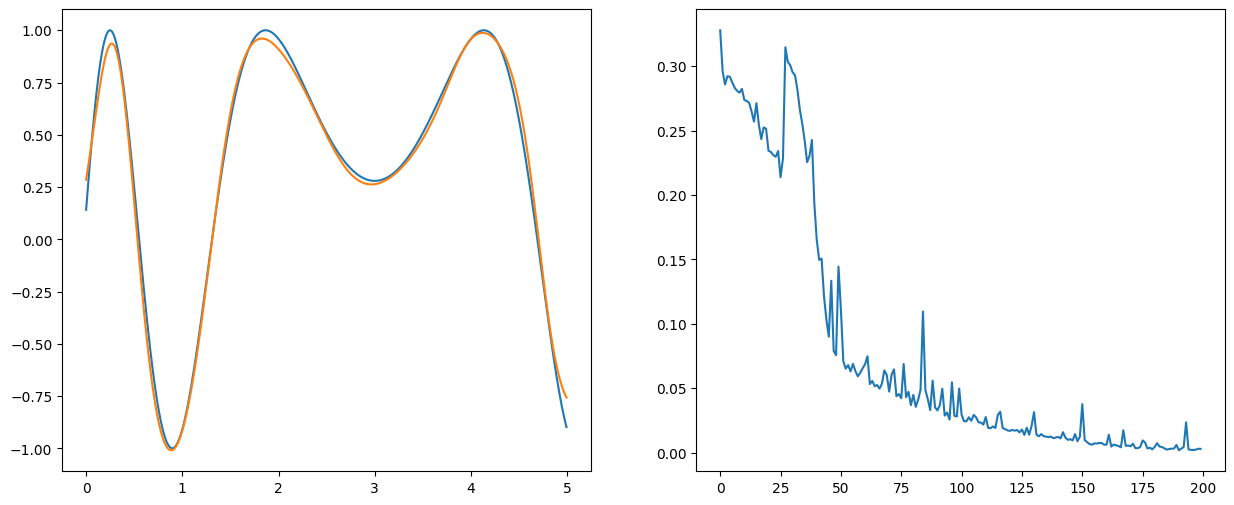

In [13]:
x = np.arange(0, 5, 0.025/4)

predictions = model(x)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(x, f(x))
ax[0].plot(x, predictions)

ax[1].plot(hist.history['loss'])

plt.show()

__Вывод__: в ходе выполнения лабораторной работы я реализовал радиально базисный слой и с помощью него построил нейросетевые модели для классификации объектов и аппроксимации функции. Обучил обе модели и убедился, что сети с радиально базисными элементами могут быть продуктивными для решения задач классификации при линейной неразделимости выборки и аппроксимации функции.